# Portuguese to English Translation using Transformer

Import libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# !pip install tensorflow-datasets
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

## Setup input pipeline

See what datasets are available

In [2]:
print(tfds.list_builders())

['abstract_reasoning', 'bair_robot_pushing_small', 'caltech101', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_corrupted', 'cnn_dailymail', 'coco2014', 'colorectal_histology', 'colorectal_histology_large', 'cycle_gan', 'diabetic_retinopathy_detection', 'dsprites', 'dtd', 'dummy_dataset_shared_generator', 'dummy_mnist', 'emnist', 'fashion_mnist', 'flores', 'glue', 'groove', 'higgs', 'horses_or_humans', 'image_label_folder', 'imagenet2012', 'imagenet2012_corrupted', 'imdb_reviews', 'iris', 'kmnist', 'lm1b', 'lsun', 'mnist', 'moving_mnist', 'multi_nli', 'nsynth', 'omniglot', 'open_images_v4', 'oxford_flowers102', 'oxford_iiit_pet', 'para_crawl', 'quickdraw_bitmap', 'rock_paper_scissors', 'shapes3d', 'smallnorb', 'squad', 'starcraft_video', 'sun397', 'svhn_cropped', 'ted_hrlr_translate', 'ted_multi_translate', 'tf_flowers', 'titanic', 'ucf101', 'voc2007', 'wikipedia', 'wmt15_translate', 'wmt16_translate', 'wmt17_translate', 'wmt18_translate', 'wmt19_t

Download dataset
* `with_info`: download `DatasetInfo`
* `as_supervised`: `tf.data.Dataset` will have 2-tuple structure `(input, label)`

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', 
                               with_info=True, 
                               as_supervised=True)

Prints out useful information about the dataset

In [4]:
print(metadata)

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=0.0.1,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.
',
    urls=['https://github.com/neulab/word-embeddings-for-nmt'],
    features=Translation({
        'en': Text(shape=(), dtype=tf.string, encoder=None),
        'pt': Text(shape=(), dtype=tf.string, encoder=None)
    },
    total_num_examples=54781,
    splits={
        'test': <tfds.core.SplitInfo num_examples=1803>,
        'train': <tfds.core.SplitInfo num_examples=51785>,
        'validation': <tfds.core.SplitInfo num_examples=1193>
    },
    supervised_keys=('pt', 'en'),
    citation='"""
        @inproceedings{Ye2018WordEmbeddings,
          author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
          title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translation},
   

`supervised_keys=('pt', 'en')` indicates that the input is `pt` and the label is `en`

`pt` => Portuguese

`en` => English

In [5]:
train_examples, val_examples = examples['train'], examples['validation']

Get list of training sentences

In [6]:
en_train_data = [en.numpy() for pt, en in train_examples]
pt_train_data = [pt.numpy() for pt, en in train_examples]

Create a custom subword tokenizer from the training dataset

In [7]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    en_train_data, target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    pt_train_data, target_vocab_size=2**13)

See how the tokenizer works

In [8]:
sample_string = "I've always been so jacked up!"

tokenized_string = tokenizer_en.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print('The original string: {}'.format(original_string))

assert sample_string == original_string

Tokenized string is [7904, 7870, 74, 260, 106, 18, 5125, 55, 217, 7864]
The original string: I've always been so jacked up!


The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary, thus there is no unknown word in the vocabulary

In [9]:
for subword in tokenized_string:
    print('{} ----> {}'.format(subword, tokenizer_en.decode([subword])))

7904 ----> I
7870 ----> '
74 ----> ve 
260 ----> always 
106 ----> been 
18 ----> so 
5125 ----> jack
55 ----> ed 
217 ----> up
7864 ----> !


In [10]:
sample_string_2 = "Hi! My name is Ryan Mink, Elon Musk's successor!"
tokenized_string_2 = tokenizer_en.encode(sample_string_2)
for subword in tokenized_string_2:
    print('{} ----> {}'.format(subword, tokenizer_en.decode([subword])))

7903 ----> H
7936 ----> i
7864 ----> !
7863 ---->  
7908 ----> M
113 ----> y 
699 ----> name 
13 ----> is 
7913 ----> R
4749 ----> yan
7863 ---->  
7908 ----> M
5128 ----> ink
7345 ----> , 
7900 ----> E
4869 ----> lon
7863 ---->  
7908 ----> M
171 ----> us
7938 ----> k
7870 ----> '
9 ----> s 
2205 ----> success
331 ----> or
7864 ----> !


In [11]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

Add a start and end token to the input and target

In [12]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
        lang1.numpy()) + [tokenizer_pt.vocab_size+1]
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
        lang2.numpy()) + [tokenizer_en.vocab_size+1]
    
    return lang1, lang2

To keep this example small and relatively fast, drop examples with a length of over 40 tokens

In [13]:
MAX_LENGTH = 40

In [14]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                          tf.size(y) <= max_length)

Operations inside `.map()` run in graph mode and receive a graph tensor that do not have a numpy attribute. The `tokenizer` expects a string or Unicode symbol to encode it into integers. Hence, you need to run the encoding inside a `tf.py_function`, which receives an eager tensor having a numpy attribute that contains the string value.

In [15]:
def tf_encode(pt, en):
    # wraps a python function into a TensorFlow op that executes it eagerly
    return tf.py_function(func=encode, inp=[pt, en], Tout=[tf.int64, tf.int64])

In [16]:
# maps tf_encode to each element of train_examples which is a tuple
train_dataset = train_examples.map(tf_encode)

# filters the dataset according to predicate e.g. max length
train_dataset = train_dataset.filter(filter_max_length)

# cache the dataset to memory to get a speedup while reading from it
train_dataset = train_dataset.cache()

# combines consecutive elements of this dataset into padded batches
# BUFFER_SIZE indicates the number of elements from which an element is randomly sampled
# for the new dataset
# the buffer is then refilled with the remaining elements from the original dataset
# -1 => pad to the maximum size of that dimension in each batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]))

# creates a Dataset that prefetches elements from this dataset
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]))

See what the batches look like

In [17]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: id=311407, shape=(64, 40), dtype=int64, numpy=
 array([[8214, 1259,    5, ...,    0,    0,    0],
        [8214,  299,   13, ...,    0,    0,    0],
        [8214,   59,    8, ...,    0,    0,    0],
        ...,
        [8214,   95,    3, ...,    0,    0,    0],
        [8214, 5157,    1, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0]])>,
 <tf.Tensor: id=311408, shape=(64, 40), dtype=int64, numpy=
 array([[8087,   18,   12, ...,    0,    0,    0],
        [8087,  634,   30, ...,    0,    0,    0],
        [8087,   16,   13, ...,    0,    0,    0],
        ...,
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   17, 4981, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0]])>)

The batch is expected to have a batch size of 64 and a sequence length of 40

In [18]:
pt_batch.shape, en_batch.shape

(TensorShape([64, 40]), TensorShape([64, 40]))

## Positional encoding

Transformer does not contain recurrence or convolution, hence positional encoding is added to encode the relative position of words in a sentence.

Formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [19]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

The positional encoding vector is added to the embedding vector for each input to the encoder and decoder

In [20]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    # apply sin to even indices in the array; 2i
    sines = np.sin(angle_rads[:, 0::2])
    
    # apply cos to odd indices in the array; 2i+1
    cosines = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    
    pos_encoding = pos_encoding[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


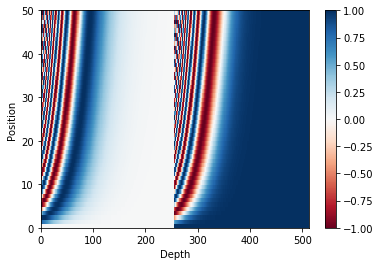

In [21]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

### Padding mask

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

The padding mask is used as follows: 

`scaled_attention_logits += (mask * -1e9)`

before it is passed to a softmax layer which turns the numbers corresponding to the padding into really small numbers (really big negative numbers), hence becoming asymptotically 0 when softmax is applied on them.

In [22]:
# seq: (batch_size, seq_len)
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # add extra dimensions so that we can add the padding
    # to the attention logits
    return seq[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)

See how it works

In [23]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=311425, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

### Look ahead mask

The mask indicates "future" elements in a sequence that come after the current element.

The look ahead mask is used as follows: 

`scaled_attention_logits += (mask * -1e9)`

before it is passed to a softmax layer which turns the numbers corresponding to the padding into really small numbers (really big negative numbers), hence becoming asymptotically 0 when softmax is applied on them.

In [24]:
# size: (seq_len)
def create_look_ahead_mask(size):
    # lower triangular part
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask # (seq_len, seq_len)

See how it works

In [25]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
x, temp

(<tf.Tensor: id=311433, shape=(1, 3), dtype=float32, numpy=array([[0.6162896 , 0.38960636, 0.88371134]], dtype=float32)>,
 <tf.Tensor: id=311441, shape=(3, 3), dtype=float32, numpy=
 array([[0., 1., 1.],
        [0., 0., 1.],
        [0., 0., 0.]], dtype=float32)>)

### Combined mask

Both the look ahead mask and padding mask are applied at the decoder layer like below:

In [26]:
x = tf.constant([[1, 2, 3, 4], [1, 2, 3, 4]])

padding_mask = create_padding_mask(x)
look_ahead_mask = create_look_ahead_mask(x.shape[1])

# combine both masks
combined_mask = tf.maximum(look_ahead_mask, padding_mask)

print('Input shape: {}'.format(x.shape))
print('Padding mask shape: {}'.format(padding_mask.shape))
print('Look ahead mask shape: {}'.format(look_ahead_mask.shape))
print('Combined mask shape: {}'.format(combined_mask.shape))

Input shape: (2, 4)
Padding mask shape: (2, 1, 1, 4)
Look ahead mask shape: (4, 4)
Combined mask shape: (2, 1, 4, 4)


## Scaled Dot-Product Attention

![scaled_attention](scaled_attention.png)

The attention function used by the transformer takes three inputs: 
* Q (query)
* K (key)
* V (value)

The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

In [27]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (batch_size, num_heads, seq_len_q, depth)
    k: key shape   == (batch_size, num_heads, seq_len_k, depth)
    v: value shape == (batch_size, num_heads, seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """
    
    # transpose_b => transpose the last two dimensions of 
    # second argument to the function
    # (batch_size, num_heads, seq_len_q, seq_len_k)
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # add the mask to the scaled tensor
    # multiplication by -1e9 forces the masked values to be
    # really small, hence 0 after softmax is applied
    # (batch_size, num_heads, seq_len_q, seq_len_k)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        
    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1
    # (batch_size, num_heads, seq_len_q, seq_len_k)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
    
    # (batch_size, num_heads, seq_len_q, seq_len_k) * (batch_size, num_heads, seq_len_v, depth_v)
    # = (batch_size, num_heads, seq_len_q, depth_v)
    output = tf.matmul(attention_weights, v) 
    
    return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and V (value) vector. This ensures that the words we want to focus on are kept as is and the irrelevant words are flushed out.

In [28]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Output = Attention weights * Values')
    print()
    print('Attention weights are:')
    print(temp_attn)
    print()
    print('Values are:')
    print(v)
    print()
    print('Output is:')
    print(temp_out)

In [29]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)

temp_v = tf.constant([[1,0],
                      [10,0],
                      [100,5],
                      [1000,6]], dtype=tf.float32)

# this `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0,10,0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Output = Attention weights * Values

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)

Values are:
tf.Tensor(
[[   1.    0.]
 [  10.    0.]
 [ 100.    5.]
 [1000.    6.]], shape=(4, 2), dtype=float32)

Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [30]:
# this query aligns with a repeated key (third and fourth),
# so all associated values get averaged
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Output = Attention weights * Values

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)

Values are:
tf.Tensor(
[[   1.    0.]
 [  10.    0.]
 [ 100.    5.]
 [1000.    6.]], shape=(4, 2), dtype=float32)

Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [31]:
# this query aligns equally with the first and second key,
# so their values get averaged
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Output = Attention weights * Values

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)

Values are:
tf.Tensor(
[[   1.    0.]
 [  10.    0.]
 [ 100.    5.]
 [1000.    6.]], shape=(4, 2), dtype=float32)

Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together

In [32]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Output = Attention weights * Values

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)

Values are:
tf.Tensor(
[[   1.    0.]
 [  10.    0.]
 [ 100.    5.]
 [1000.    6.]], shape=(4, 2), dtype=float32)

Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

![multi_head_attention](multi_head_attention.png)

Multi-head attention consists of four parts:
* Linear layers and split into heads
* Scaled dot-product attention
* Concatenation of heads
* Final linear layer

Each multi-head attention block gets three inputs:
* Q (query)
* K (key)
* V (value)

These are put through linear (Dense) layers and split up into multiple heads.

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step. The attention output for each head is then concatenated (using `tf.transpose` and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads **because** it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [33]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """
        split the last dimension into (num_heads, depth)
        transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q) # (batch_size, seq_len, d_model)
        k = self.wk(k) # (batch_size, seq_len, d_model)
        v = self.wv(v) # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size) # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size) # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size) # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_v, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask) 
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # (batch_size, seq_len_v, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model)) # (batch_size, seq_len_v, d_model)
        
        output = self.dense(concat_attention) # (batch_size, seq_len_v, d_model)
        
        return output, attention_weights

At each location in the sequence `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [34]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512)) # (batch_size, encoder_sequence_length, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

Below example shows how multi-head attention works

In [35]:
batch_size = 3
seq_len = 5
d_model = 128
num_heads = 8
depth = d_model // num_heads # 128/8 = 16
raw_input = tf.ones((batch_size, seq_len))
embedding_matrix = tf.ones((batch_size, seq_len, d_model))

print('Shape of multi-head attention block input: {}'.format(embedding_matrix.shape))

# split inputs into multiple heads
def split_heads(embedding_matrix):
    embedding_matrix = tf.reshape(embedding_matrix, (batch_size, -1, num_heads, depth))
    embedding_matrix = tf.transpose(embedding_matrix, perm=[0, 2, 1, 3])
    return embedding_matrix

q = split_heads(embedding_matrix) # (batch_size, num_heads, seq_len_q, depth)
k = split_heads(embedding_matrix) # (batch_size, num_heads, seq_len_k, depth)
v = split_heads(embedding_matrix) # (batch_size, num_heads, seq_len_v, depth)

print('Shape of input split heads: {}'.format(q.shape))

# matrix multiplication in scaled dot-product attention layer
matmul_qk = tf.matmul(q, k, transpose_b=True)

print('Shape of matrix multiplication between Q and K: {}'.format(matmul_qk.shape))

# create combined mask
combined_mask = tf.maximum( create_look_ahead_mask(raw_input.shape[1]), create_padding_mask(raw_input))

print('Shape of combined mask: {}'.format(combined_mask.shape))

# apply combined mask
masked_matmul_qk = matmul_qk + (combined_mask * -1e9)

print('Shape of masked matrix multiplication between Q and K: {}'.format(masked_matmul_qk.shape))

# apply softmax
attention_weights = tf.nn.softmax(masked_matmul_qk, axis=-1)

print('Shape of attention weights: {}'.format(attention_weights.shape))

# scaled dot product attention output
scaled_dot_product_attention_output = tf.matmul(attention_weights, v)

print('Shape of scaled dot product attention output: {}'.format(scaled_dot_product_attention_output.shape))

# transpose multi head attention outputs
scaled_attention = tf.transpose(scaled_dot_product_attention_output, perm=[0, 2, 1, 3])

print('Shape of transposed multi head attention outputs: {}'.format(scaled_attention.shape))

# concatenate multi head attention outputs
concat_attention = tf.reshape(scaled_attention, (batch_size, -1, d_model))

print('Shape of concatenated multi head attention outputs: {}'.format(concat_attention.shape))

Shape of multi-head attention block input: (3, 5, 128)
Shape of input split heads: (3, 8, 5, 16)
Shape of matrix multiplication between Q and K: (3, 8, 5, 5)
Shape of combined mask: (3, 1, 5, 5)
Shape of masked matrix multiplication between Q and K: (3, 8, 5, 5)
Shape of attention weights: (3, 8, 5, 5)
Shape of scaled dot product attention output: (3, 8, 5, 16)
Shape of transposed multi head attention outputs: (3, 5, 8, 16)
Shape of concatenated multi head attention outputs: (3, 5, 128)


As one can see, the multi-head attention block input undergoes multiple shape transformations before ends with its initial shape.

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [36]:
# dff is feed forward layer hidden units
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'), # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model) # (batch_size, seq_len, d_model)
    ])

In [37]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and Decoder

![transformer](transformer.png)

The transformer model follows the same general pattern as a standard sequence to sequence with attention model.
* The input sentence is passed through `N` encoder layers that generate an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word.

`tf.keras.layers.LayerNormalization` is not available in TensorFlow 2.0 by the time of this writing. Thus we need to use our own function.

In [38]:
def layer_normalization(inputs, epsilon = 1e-8, scope="layer_normalization"):
    '''
    Applies layer normalization. See https://arxiv.org/abs/1607.06450.
    inputs: A tensor with 2 or more dimensions, where the first dimension has `batch_size`.
    epsilon: A floating number. A very small number for preventing ZeroDivision Error.
    scope: Optional scope for `variable_scope`.
      
    Returns:
      A tensor with the same shape and data dtype as `inputs`.
    '''
    
    inputs_shape = inputs.get_shape()
    params_shape = inputs_shape[-1:]

    mean, variance = tf.nn.moments(inputs, [-1], keepdims=True)
    
    # TODO: figure out how to instantiate the variable only once
    # in the meantime, we can comment them out because
    # they do not affect the outputs
    #beta = tf.Variable(tf.zeros(shape=params_shape), name="beta")
    #gamma = tf.Variable(tf.ones(shape=params_shape), name="gamma")
    
    normalized = (inputs - mean) / ( (variance + epsilon) ** (.5) )
    # TODO: figure out how to instantiate the variable only once
    # in the meantime, we can comment them out because
    # they do not affect the outputs
    #outputs = gamma * normalized + beta
    outputs = normalized
        
    return outputs

### Encoder layer

Each encoder layer consists of sublayers:
1. Multi-head attention (with padding mask)
2. Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [39]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        # TODO: uncomment below when they become available in TensorFlow 2.0
        #self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        #self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask) # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = layer_normalization(x + attn_output, epsilon=1e-6) # (batch_size, input_seq_len, d_model)
        
        ffn_output = self.ffn(out1) # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = layer_normalization(out1 + ffn_output, epsilon=1e-6) # (batch_size, input_seq_len, d_model)
        
        return out2

In [40]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Each decoder layer consists of sublayers:
1. Masked multi-head attention (with look ahead mask and padding mask)
2. Multi-head attention (with padding mask). V (value) and K (key) receive the encoder output as inputs. Q (query) receives the output from the masked multi-head attention sublayer
3. Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output.

In [41]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        
        attn1, attn_weights_block1 = self.mha1(
            x, x, x, look_ahead_mask) # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = layer_normalization(attn1 + x, epsilon=1e-6)
        
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask) # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = layer_normalization(attn2 + out1, epsilon=1e-6) # (batch_size, target_seq_len, d_model)
        
        ffn_output = self.ffn(out2) # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = layer_normalization(ffn_output + out2) # (batch_size, target_seq_len, d_model)
        
        return out3, attn_weights_block1, attn_weights_block2

In [42]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _, = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

Encoder consists of:
1. Input Embedding
2. Positional Encoding
3. N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [43]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        x = self.embedding(x) # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        # add the positional encoding matrix to the embedding matrix
        # embedding shape: (batch_size, input_seq_len, d_model)
        # positional encoding shape: (1, input_seq_len, d_model)
        # the positional encoding matrix is broadcast 
        # across the embedding matrix
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
            
        return x # (batch_size, input_seq_len, d_model)

In [44]:
sample_encoder = Encoder(num_layers=2, 
                         d_model=512, 
                         num_heads=8, 
                         dff=2048, 
                         input_vocab_size=8500)

sample_encoder_output = sample_encoder(tf.random.uniform((64, 62)), 
                                       training=False, 
                                       mask=None)

print(sample_encoder_output.shape) # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

Decoder consists of:
1. Output Embedding
2. Positional Encoding
3. N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [45]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)
        
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x) # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
            
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [46]:
sample_decoder = Decoder(num_layers=2, 
                         d_model=512, 
                         num_heads=8, 
                         dff=2048, 
                         target_vocab_size=8000)

output, attn = sample_decoder(tf.random.uniform((64, 26)),
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

Transformer consists of the encoder, decoder, and a final linear layer. The output of the decoder is the input to the linear layer and output is returned.

In [47]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                 target_vocab_size, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        # (batch_size, inp_seq_len, d_model)
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        # (batch_size, tar_seq_len, target_vocab_size)
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights

In [48]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000)

temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None, 
                               dec_padding_mask=None)

fn_out.shape # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 26, 8000])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers*, *d_model*, and *dff* have been reduced.

In [49]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [50]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        # asymptotically decreases
        # step is in the denominator
        arg1 = tf.math.rsqrt(step) # rsqrt = reciprocal square root
        
        # asymptotically increases
        # step is in the numerator
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [51]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

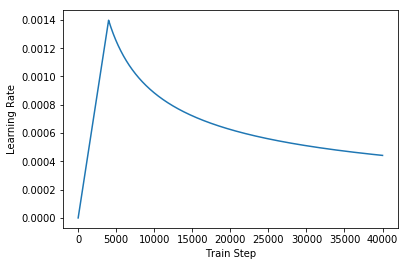

In [52]:
temp_learning_rate_schedule = CustomSchedule(d_model, warmup_steps=4000)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [53]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [54]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

### Metrics

Here's the flow:
* Instantiate the metric at the start of the loop
* Call `metric.update_state()` or simply `metric()` after each batch to add the latest value
* Call `metric.result()` when you need to display the current value of the metric
* Call `metric.reset_states()` when you need to clear the state of the metric (typically at the end of an epoch)

Prepare the metrics

In [55]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

See how it works:

In [56]:
# Start with a clean state
train_loss.reset_states()
print(train_loss.result())

# Add a value
train_loss(10)
print(train_loss.result())

# Add another value
train_loss(20)
print(train_loss.result())

# Add a value by calling the update function
train_loss.update_state(30)
print(train_loss.result())

# Reset the state
train_loss.reset_states()
print(train_loss.result())

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(10.0, shape=(), dtype=float32)
tf.Tensor(15.0, shape=(), dtype=float32)
tf.Tensor(20.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


## Training and checkpointing

In [57]:
transformer = Transformer(num_layers, d_model, num_heads, dff, 
                          input_vocab_size, target_vocab_size, dropout_rate)

In [58]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
    
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
    
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [59]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer, 
                           optimizer=optimizer)

# max_to_keep => number of most recent checkpoints to keep in the "active set" (memory)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


The target is divided into tar_inp and tar_real. 

`tar_inp` is passed as an input to the decoder. 

`tar_real` is the target shifted by 1: At each location in `tar_input`, `tar_real` contains the next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` = "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses teacher-forcing. Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

In [60]:
EPOCHS = 20

Define a training step for a batch

In [61]:
# Compile the function below using @tf.function.
# It makes a graph out of the function.
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    # Open a GradientTape to record the operations run
    # during the forward pass, which enables automatic differentiation
    with tf.GradientTape() as tape:
        
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
        predictions, _ = transformer(inp, 
                                     tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        
        # Compute the loss value for this minibatch
        loss = loss_function(tar_real, predictions)
    
    # Use the gradient tape to automatically retrieve
    # the gradients of the loss function with respect to the trainable variables.
    gradients = tape.gradient(loss, transformer.trainable_variables)
    
    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    # Update training metrics.
    train_loss(loss)
    train_accuracy(tar_real, predictions)

Portuguese is used as the input language and English is the target language

In [60]:
for epoch in range(EPOCHS):
    start_time = time.time()
    
    # Clear the states of the metrics
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        if batch % 500 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result()))
            
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch+1, 
                                                            ckpt_save_path))
     
    # Display metrics at the end of each epoch
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                        train_loss.result(), 
                                                        train_accuracy.result()))
    
    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start_time))

Epoch 1 Batch 0 Loss 4.2226 Accuracy 0.0000
Epoch 1 Batch 500 Loss 3.6184 Accuracy 0.0383
Epoch 1 Loss 3.3939 Accuracy 0.0497
Time taken for 1 epoch: 328.92441987991333 secs

Epoch 2 Batch 0 Loss 2.6835 Accuracy 0.0942
Epoch 2 Batch 500 Loss 2.4744 Accuracy 0.1155
Epoch 2 Loss 2.4156 Accuracy 0.1210
Time taken for 1 epoch: 298.55204010009766 secs

Epoch 3 Batch 0 Loss 2.2309 Accuracy 0.1324
Epoch 3 Batch 500 Loss 2.1683 Accuracy 0.1459
Epoch 3 Loss 2.1348 Accuracy 0.1493
Time taken for 1 epoch: 297.4669771194458 secs

Epoch 4 Batch 0 Loss 2.0029 Accuracy 0.1608
Epoch 4 Batch 500 Loss 1.9367 Accuracy 0.1742
Epoch 4 Loss 1.9039 Accuracy 0.1779
Time taken for 1 epoch: 297.0560097694397 secs

Epoch 5 Batch 0 Loss 1.7669 Accuracy 0.1920
Epoch 5 Batch 500 Loss 1.7352 Accuracy 0.1995
Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-1
Epoch 5 Loss 1.7098 Accuracy 0.2021
Time taken for 1 epoch: 295.3261592388153 secs

Epoch 6 Batch 0 Loss 1.6029 Accuracy 0.2134
Epoch 6 Batch 500 Loss 1

## Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the Portuguese tokenizer (`tokenizer_pt`). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == tokenizer_en.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatenate the predicted word to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

In [82]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]
    
    # Input sentence is portuguese, hence adding the start and end token
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    
    # Turn the input into a batch of size 1
    encoder_input = tf.expand_dims(inp_sentence, 0)
    
    # As the target is english, the first word to the transformer should be the
    # english start token
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)
        
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output, 
                                                     False, 
                                                     enc_padding_mask, 
                                                     combined_mask, 
                                                     dec_padding_mask)
        
        # select the last word from the seq_len dimension
        # seq_len is the current sequence length of the target
        predictions = predictions[:, -1:, :] # (batch_size, 1, vocab_size)
        
        # (batch_size, 1)
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, tokenizer_en.vocab_size+1):
            # final output: (seq_len)
            return tf.squeeze(output, axis=0), attention_weights
        
        # concatenate the predicted_id to the output which is given to the decoder
        # as its input
        # (batch_size, seq_len)
        output = tf.concat([output, predicted_id], axis=-1)
       
    # final output: (seq_len)
    return tf.squeeze(output, axis=0), attention_weights

In [83]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
    
    sentence = tokenizer_pt.encode(sentence)
    
    # There are 8 attention weights in the attention dictionary
    # 4 decoder layers with 2 blocks each
    # (num_heads, seq_len_q, seq_len_k)
    attention = tf.squeeze(attention[layer], axis=0)
    
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)
        
        # Plot the attention weights
        # Notice that we ignore the last element in the first dimension.
        # Thus, the first element in the first dimenstions indicates the
        # Portuguese subword/token the model pays attention to the most
        # in generating the English equivalent subword/token
        ax.matshow(attention[head][:-1, :], cmap='viridis')
        
        fontdict = {'fontsize': 10}
        
        # The x axis corresponds to the key: Portuguese
        ax.set_xticks(range(len(sentence)+2))
        
        # The y axis corresponds to the query: English
        ax.set_yticks(range(len(result)))
        
        ax.set_ylim(len(result)-1.5, -0.5)
        
        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)
        
        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)
        
        ax.set_xlabel('Head {}'.format(head+1))
        
    plt.tight_layout()
    plt.show()

In [84]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
    
    predicted_sentence = tokenizer_en.decode([i for i in result 
                                              if i < tokenizer_en.vocab_size])
    
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
    
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [85]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: this is a problem that we have to solve the truth .
Real translation: this is a problem we have to solve .


In [86]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors heard about this idea .
Real translation: and my neighboring homes heard about this idea .


In [87]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm very quickly going to share with you a few key stories that happened .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


In [88]:
translate("Ele é o melhor jogador de futebol do mundo")
print("Real translation: He is the best soccer player in the world")

Input: Ele é o melhor jogador de futebol do mundo
Predicted translation: it takes the best football button in the world .
Real translation: He is the best soccer player in the world


Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book that i did .


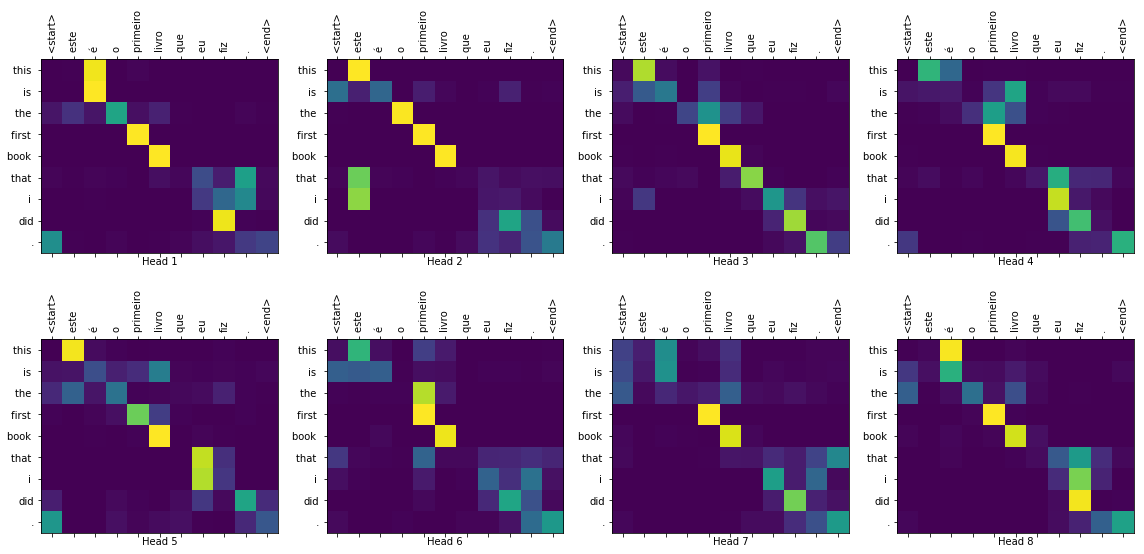

Real translation: this is the first book i've ever done.


In [89]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")